***
# This a DNN Siamese network for the fashion mnist dataset

***

In [14]:
### Importing all the libraries needed

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, Lambda
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.python.keras.utils.vis_utils import plot_model
from tensorflow.keras import backend as K


import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageFont, ImageDraw
import random

# Load and normalize data


In [15]:



(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()


train_images = train_images.astype('float32') / (255.0)
test_images = test_images.astype('float32') / (255.0)

print(train_images.shape)
print(test_images.shape)

(60000, 28, 28)
(10000, 28, 28)


In [16]:
### Functions for Preprocessing and separating the data 

def create_pairs(x, digit_indices):
    '''Positive and negative pair creation.
    Alternates between positive and negative pairs.
    '''
    pairs = []
    labels = []
    n = min([len(digit_indices[d]) for d in range(10)]) - 1
    
    for d in range(10):
        for i in range(n):
            z1, z2 = digit_indices[d][i], digit_indices[d][i + 1]
            pairs += [[x[z1], x[z2]]]
            inc = random.randrange(1, 10)
            dn = (d + inc) % 10
            z1, z2 = digit_indices[d][i], digit_indices[dn][i]
            pairs += [[x[z1], x[z2]]]
            labels += [1, 0]
            
    return np.array(pairs), np.array(labels)



def create_pairs_on_set(images, labels):
    
    digit_indices = [np.where(labels == i)[0] for i in range(10)]
    pairs, y = create_pairs(images, digit_indices)
    y = y.astype('float32')
    
    return pairs, y


def show_image(image):
    plt.figure()
    plt.imshow(image)
    plt.colorbar()
    plt.grid(False)
    plt.show()

### Creating data pairs 

In [17]:


tr_pairs, tr_y = create_pairs_on_set(train_images, train_labels)
ts_pairs, ts_y = create_pairs_on_set(test_images, test_labels)

ts_pairs.shape

### You can see we know have a shape that includes pairs

(19980, 2, 28, 28)

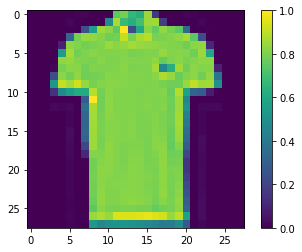

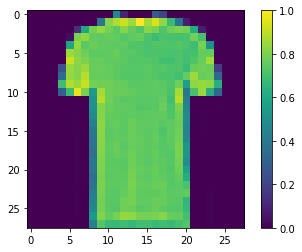

The label Y for this pair is 1.0


In [18]:
### Let's see some examples

pair = 10


show_image(ts_pairs[pair][0])
show_image(ts_pairs[pair][1])

print(f'The label Y for this pair is {ts_y[pair]}')

# Building the Siamese Model

In [19]:
def initialize_base_network():
    input = Input(shape=(28,28,), name="base_input")
    x = Flatten(name="flatten_input")(input)
    x = Dense(128, activation='relu', name="first_base_dense")(x)
    x = Dropout(0.1, name="first_dropout")(x)
    x = Dense(128, activation='relu', name="second_base_dense")(x)
    x = Dropout(0.1, name="second_dropout")(x)
    x = Dense(128, activation='relu', name="third_base_dense")(x)

    return Model(inputs=input, outputs=x)


def euclidean_distance(vects):
    x, y = vects
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))


def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

In [21]:
### Initiate the network

base_network = initialize_base_network()



In [23]:
### Split the inputs into a and b that will go into the Base network

input_a = Input(shape=(28,28,), name="left_input")
vect_output_a = base_network(input_a)



input_b = Input(shape=(28,28,), name="right_input")
vect_output_b = base_network(input_b)


output = Lambda(euclidean_distance, name="output_layer", output_shape=eucl_dist_output_shape)([vect_output_a, vect_output_b])

model = Model([input_a, input_b], output)



In [24]:
### Construct the loss function 

def contrastive_loss_with_margin(margin):
    def contrastive_loss(y_true, y_pred):
        '''Contrastive loss from Hadsell-et-al.'06
        http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
        '''
        square_pred = K.square(y_pred)
        margin_square = K.square(K.maximum(margin - y_pred, 0))
        return (y_true * square_pred + (1 - y_true) * margin_square)
    return contrastive_loss

In [25]:
### compile the model 


model.compile(loss=contrastive_loss_with_margin(margin=1), optimizer='RMSprop')

history = model.fit([tr_pairs[:,0], tr_pairs[:,1]], tr_y, epochs=20, batch_size=128,
                    validation_data=([ts_pairs[:,0], ts_pairs[:,1]], ts_y))

938/938 [==============================] - 9s 9ms/step - loss: 0.1135 - val_loss: 0.0855
Epoch 2/20
938/938 [==============================] - 8s 9ms/step - loss: 0.0805 - val_loss: 0.0763
Epoch 3/20
938/938 [==============================] - 8s 8ms/step - loss: 0.0702 - val_loss: 0.0707
Epoch 4/20
938/938 [==============================] - 8s 9ms/step - loss: 0.0657 - val_loss: 0.0704
Epoch 5/20
938/938 [==============================] - 8s 9ms/step - loss: 0.0630 - val_loss: 0.0680
Epoch 6/20
938/938 [==============================] - 8s 9ms/step - loss: 0.0607 - val_loss: 0.0649
Epoch 7/20
938/938 [==============================] - 8s 9ms/step - loss: 0.0589 - val_loss: 0.0688
Epoch 8/20
938/938 [==============================] - 9s 9ms/step - loss: 0.0576 - val_loss: 0.0664
Epoch 9/20
938/938 [==============================] - 9s 9ms/step - loss: 0.0565 - val_loss: 0.0661
Epoch 10/20
938/938 [==============================] - 8s 9ms/step - loss: 0.0554 - val_loss: 0.0637
Epoch 11/2

In [26]:
def compute_accuracy(y_true, y_pred):

    pred = y_pred.ravel() < 0.5
    return np.mean(pred == y_true)




In [27]:
### Evaluate the model

loss = model.evaluate(x=[ts_pairs[:,0],ts_pairs[:,1]], y=ts_y)

y_pred_train = model.predict([tr_pairs[:,0], tr_pairs[:,1]])
train_accuracy = compute_accuracy(tr_y, y_pred_train)

y_pred_test = model.predict([ts_pairs[:,0], ts_pairs[:,1]])
test_accuracy = compute_accuracy(ts_y, y_pred_test)

print("Loss = {}, Train Accuracy = {} Test Accuracy = {}".format(loss, train_accuracy, test_accuracy))

625/625 [==============================] - 1s 2ms/step - loss: 0.0670
Loss = 0.06695926189422607, Train Accuracy = 0.9347141190198366 Test Accuracy = 0.9084084084084084


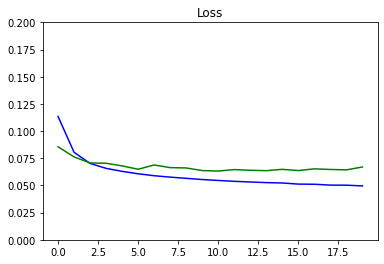

In [28]:
### Visualize the metrics 


def plot_metrics(metric_name, title, ylim=5):
    plt.title(title)
    plt.ylim(0,ylim)
    plt.plot(history.history[metric_name],color='blue',label=metric_name)
    plt.plot(history.history['val_' + metric_name],color='green',label='val_' + metric_name)


plot_metrics(metric_name='loss', title="Loss", ylim=0.2)